## TUTORIAL 05 - Exact Parametrized Functions for non-affine elliptic problems
**_Keywords: exact parametrized functions_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional square domain $\Omega = (-1, 1)^2$.
The boundary $\partial\Omega$ is kept at a reference temperature (say, zero). The conductivity coefficient is fixed to 1, while the heat source is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = \exp\{ -2 (x_0-\mu_0)^2 - 2 (x_1 - \mu_1)^2\} \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

The parameter vector $\boldsymbol{\mu}$, given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
affects the center of the Gaussian source $g(\boldsymbol{x}; \boldsymbol{\mu})$, which could be located at any point $\Omega$. Thus, the parameter domain is
$$
\mathbb{P}=[-1,1]^2.
$$

In order to be able to compare the interpolation methods (EIM and DEIM) used to solve this problem, we propose to use an exact solution of the problem.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

We will directly provide a weak formulation for this problem
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that</center>

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \left\{ v \in H^1(\Omega(\mu_0)): v|_{\partial\Omega} = 0\right\}
$$
Note that, as in the previous tutorial, the function space is parameter dependent due to the shape variation. 
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u,v;\boldsymbol{\mu}) = \int_{\Omega} \nabla u \cdot \nabla v \ d\boldsymbol{x}$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v;\boldsymbol{\mu}) = \int_\Omega g(\boldsymbol{\mu}) v  \ d\boldsymbol{x}.$$

In [1]:
import sys
sys.path.append("../../MLniCS/")


from mlnics import NN, Losses, Normalization
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

The parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu})$ is trivially affine.
The exact solution will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$ to obtain an efficient (exact affine) expansion of $f(\cdot; \boldsymbol{\mu})$.

In [2]:
@ExactParametrizedFunctions()
class Gaussian(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.f = ParametrizedExpression(
            self, "exp(- 2 * pow(x[0] - mu[0], 2) - 2 * pow(x[1] - mu[1], 2))", mu=(0., 0.),
            element=V.ufl_element())
        # note that we cannot use self.mu in the initialization of self.f, because self.mu has not been initialized yet

    # Return custom problem name
    def name(self):
        return "GaussianExact"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return 1.

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        if term == "a":
            return (1.,)
        elif term == "f":
            return (1.,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx
            return (a0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 2),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/gaussian.xml")
subdomains = MeshFunction("size_t", mesh, "data/gaussian_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/gaussian_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the Gaussian class

In [5]:
problem = Gaussian(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(-1.0, 1.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = ReducedBasis(problem)
reduction_method.set_Nmax(20)
reduction_method.set_tolerance(1e-4)

### 4.5. Perform the offline phase

In [7]:
reduction_method.initialize_training_set(10)
reduced_problem = reduction_method.offline()

In [8]:
reduction_method.initialize_testing_set(10)
net = NN.RONN(problem, reduction_method)

In [9]:
input_normalization = Normalization.IdentityNormalization()
output_normalization = Normalization.IdentityNormalization()

In [10]:
pdnn_loss = Losses.PDNN_Loss(net, output_normalization)
pinn_loss = Losses.PINN_Loss(net)
prnn_loss = Losses.PRNN_Loss(net, output_normalization, omega=1.)

In [14]:
NN.train(net, pdnn_loss, input_normalization, lr=0.001, epochs=10000)

0 1.2906964490540254e-06 	mean error(validation) = 0.308119001321699
100 2.3480721343114837e-07 	mean error(validation) = 0.002041649078981752
200 7.663921496379159e-08 	mean error(validation) = 0.001479630834608149
300 3.864897619624041e-08 	mean error(validation) = 0.0010594701896625366
400 2.1888876827833124e-08 	mean error(validation) = 0.0008146333915175347
500 1.3849744861892949e-08 	mean error(validation) = 0.0006769068188058206
600 1.296905884003056e-08 	mean error(validation) = 0.0009273762458489809
700 2.2420644759208583e-06 	mean error(validation) = 0.007314297582318968
800 2.8021889176552178e-08 	mean error(validation) = 0.0006195745622250195
900 2.573051833195237e-08 	mean error(validation) = 0.0007794245966306738
1000 2.026128238833525e-07 	mean error(validation) = 0.003223194355458212
1100 9.674492359307321e-07 	mean error(validation) = 0.0025551987181118125
1200 3.2647485218513944e-07 	mean error(validation) = 0.0029556084800394134
1300 5.366374261520193e-07 	mean error

KeyboardInterrupt: 

### 4.6. Perform an online solve

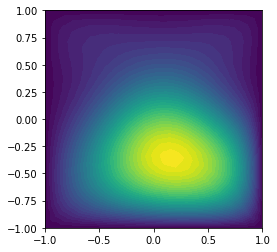

In [15]:
online_mu = (0.3, -1.0)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()
plot(reduced_solution, reduced_problem=reduced_problem)

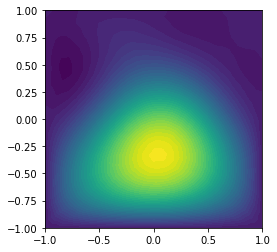

In [16]:
net.eval()
with torch.no_grad():
    online_mu_nn = torch.tensor(online_mu)
    reduced_solution_nn = net.solve(online_mu_nn, input_normalization, output_normalization)
net.train()

plot(reduced_solution_nn, reduced_problem=reduced_problem)

### 4.7. Perform an error analysis

In [ ]:
reduction_method.initialize_testing_set(50)
reduction_method.error_analysis(filename="error_analysis")